# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [39]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import sys

nb = nbformat.read("LOF_Ngram.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 697


## 1. Familiarization task – 1 A4

In [40]:
data = "train_data.csv"
df1 = pd.read_csv(data)
# original_data = df1
# df1 = df1.drop(['Id'], axis=1)

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

In [9]:
clf = LocalOutlierFactor(n_neighbors=30)
df1_lof = df1.drop(['Timestamp', 'Label', 'Id'],axis=1)
y_pred = clf.fit_predict(df1_lof)
del df1_lof
indexes_outliers = []
for i in range(len(y_pred)):
    if y_pred[i] == -1:
        indexes_outliers.append(i)

outliers = df1.iloc[indexes_outliers]
del indexes_outliers
outliers = outliers['Id']

y_pred_negative = [y_pred[i] for i in outliers]
y_pred_positive = [y_pred[i] for i in df1['Id'] if i not in outliers]
del y_pred

timestamps = df1['Timestamp']
timestamps_negative = [datetime.strptime(timestamps[i].strip(), '%d/%m/%Y %I:%M:%S %p') for i in outliers]
postive_indexes = range(len(df1))
timestamps_positive = [datetime.strptime(timestamps[i].strip(), '%d/%m/%Y %I:%M:%S %p') for i in df1['Id'] if i not in outliers]
del outliers
del timestamps

### 2b. Analysis and answers to the questions

1285


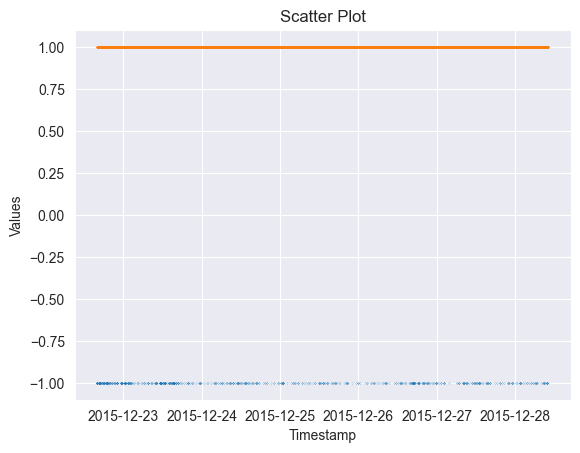

In [10]:
# Create scatter plot
plt.scatter(timestamps_negative[::2], y_pred_negative[::2], s=0.03)
plt.scatter(timestamps_positive[::50], y_pred_positive[::50], s=0.03)
print(len(y_pred_negative))
# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Scatter Plot')

plt.show()

In [11]:
del y_pred_negative
del y_pred_positive
del timestamps_positive
del timestamps_negative

## 5. N-gram task – 1/2 A4 - Individual

In [41]:
df1_ngram = df1.copy()
del df1
# Strip leading spaces from 'timestamps' column
df1_ngram['Timestamp'] = df1_ngram['Timestamp'].str.strip()

# Convert 'timestamps' column to datetime objects
df1_ngram['Timestamp'] = pd.to_datetime(df1_ngram['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
#differencing
df1_ngram['differenced_LIT301'] = df1_ngram['LIT301'].diff()

## Without differencing

In [42]:
# Define the number of bins
num_bins = 15
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['LIT301'], num_bins, labels=False, duplicates='drop')
# Define the length of the sliding window for N-grams
n_gram_length = 5
M = 3500
# Create sliding windows and extract N-grams
n_grams = []
for i in tqdm(range(len(df1_ngram) - n_gram_length + 1)):
    window = df1_ngram['bin'].iloc[i:i+n_gram_length]
    n_gram = tuple(window)
    n_grams.append(n_gram)

# Add the N-grams to the DataFrame
df1_ngram['n_gram'] = [None] * (n_gram_length - 1) + n_grams
# Group by the larger sliding window and N-gram, and count occurrences
n_gram_counts = df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')

# Pivot the dataframe
table = n_gram_counts.pivot(columns='n_gram', values='count').fillna(0)
# Calculate pairwise cosine distances
distances = cosine_distances(table)
del table
# Find the nearest neighbor for each row
nearest_neighbors = distances.argsort(axis=1)[:, 1]
nearest_neighbor_distances = distances[np.arange(len(distances)), nearest_neighbors]
del distances

100%|██████████| 496796/496796 [00:14<00:00, 33846.20it/s]


In [43]:
anomalies = []
for i in range(len(nearest_neighbor_distances)):
    if nearest_neighbor_distances[i] > 0:
        # Get the index of the sliding window that is seen as an anomalie
        anomalies.append(df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')['level_0'][i])
print(len(nearest_neighbor_distances))
del n_gram_counts
del nearest_neighbor_distances
del nearest_neighbors

20375


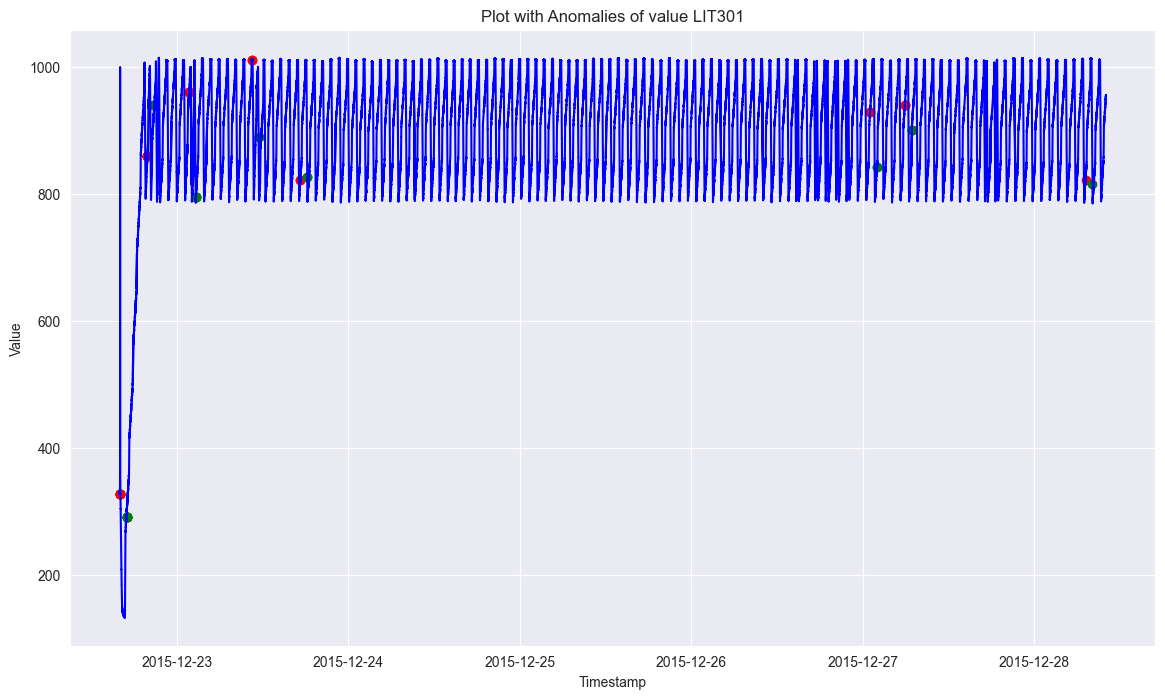

In [44]:
timestamps = df1_ngram['Timestamp']
timestamps = [timestamps[i] for i in range(0, len(timestamps))]
values = df1_ngram['LIT301']
plt.rcParams['figure.figsize'] = [14, 8]
# Plot the values
plt.plot(timestamps, values, color='blue')

# Highlight anomalies with a different color
for idx in anomalies:
    plt.scatter(timestamps[idx * M], values[idx * M], color='red')
    plt.scatter(timestamps[idx * M + M], values[idx * M + M], color='green')
del anomalies
# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot with Anomalies of value LIT301')
# plt.ylim(800, 1025)

# Show the plot
plt.show()
del values
del timestamps

## With differencing

In [45]:
# Define the number of bins
num_bins = 15
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['differenced_LIT301'], num_bins, labels=False, duplicates='drop')
df1_ngram['bin'][0] = 0

# Define the length of the sliding window for N-grams
n_gram_length = 3
M = 40000
# Create sliding windows and extract N-grams
n_grams = []
for i in tqdm(range(len(df1_ngram) - n_gram_length + 1)):
    window = df1_ngram['bin'].iloc[i:i+n_gram_length]
    n_gram = tuple(window)
    n_grams.append(n_gram)

# Get the sizes of variables in the global namespace
variables = globals().items()
variable_sizes = [(var, sys.getsizeof(obj)) for var, obj in variables]

# Sort the variables by size in descending order
variable_sizes.sort(key=lambda x: x[1], reverse=True)
# Add the N-grams to the DataFrame
df1_ngram['n_gram'] = [None] * (n_gram_length - 1) + n_grams
del n_grams
# Group by the larger sliding window and N-gram, and count occurrences
n_gram_counts = df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')

# Pivot the dataframe
table = n_gram_counts.pivot(columns='n_gram', values='count').fillna(0)
del n_gram_counts
# Calculate pairwise cosine distances
distances = cosine_distances(table)
del table
n_gram_counts = df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')

# Find the nearest neighbor for each row
nearest_neighbors = distances.argsort(axis=1)[:, 1]
nearest_neighbor_distances = distances[np.arange(len(distances)), nearest_neighbors]
del distances


C:\Users\ottev\AppData\Local\Temp\ipykernel_18876\4090110946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_ngram['bin'][0] = 0
100%|██████████| 496798/496798 [00:14<00:00, 33481.94it/s]


In [46]:
anomalies = []
for i in range(len(nearest_neighbor_distances)):
    if nearest_neighbor_distances[i] > 0:
        # Get the index of the sliding window that is seen as an anomalie
        anomalies.append(df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')['level_0'][i])
print(len(nearest_neighbor_distances))
del n_gram_counts
del nearest_neighbor_distances
del nearest_neighbors

41919


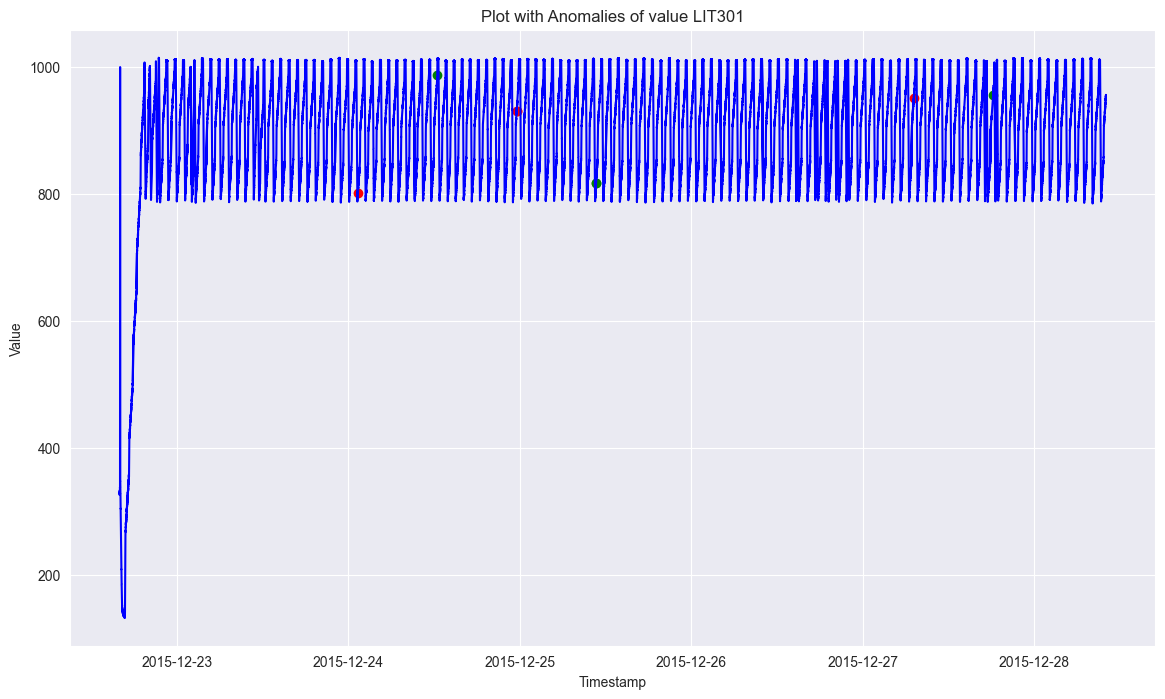

In [47]:
timestamps = df1_ngram['Timestamp']
timestamps = [timestamps[i] for i in range(0, len(timestamps))]
values = df1_ngram['LIT301']
plt.rcParams['figure.figsize'] = [14, 8]
# Plot the values
plt.plot(timestamps, values, color='blue')

# Highlight anomalies with a different color
for idx in anomalies:
    plt.scatter(timestamps[idx * M], values[idx * M], color='red')
    plt.scatter(timestamps[idx * M + M], values[idx * M + M], color='green')
del anomalies
# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot with Anomalies of value LIT301')
# plt.ylim(800, 1025)

# Show the plot
plt.show()
del values
del timestamps

### 5a. Visualise discretization

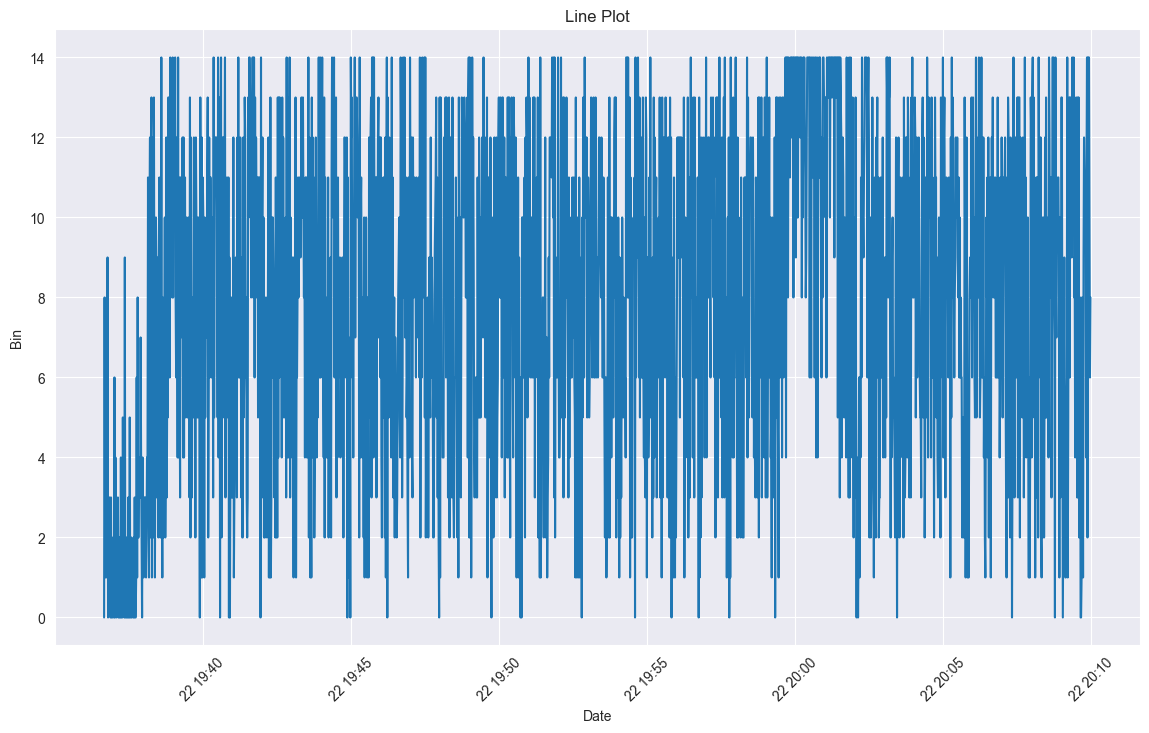

In [48]:
# Sort the DataFrame by 'Timestamp' column
df1_ngram = df1_ngram.sort_values('Timestamp')

# Create the line plot
plt.plot(df1_ngram['Timestamp'][13000:15000], df1_ngram['bin'][13000:15000])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Bin')
plt.title('Line Plot')

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [49]:
data = "train_data.csv"
df1 = pd.read_csv(data)

### 5b. Analysis and answers to the questions. Also provide relevant plots.

### Difference of differencing
Adding in differencing into the pipeline limitted the memory that could be used for creating the ngrams and therefor required parameters that were worse than the setting that could be done without the differencing. This leaded to very poor results for the differencing.
### Types of anomalies
Detected anomalies are often found in the spikes and the start-up sequence is also always detected as an anomaly. The anomalies are based on a single point given the context.

100%|██████████| 496796/496796 [00:15<00:00, 32557.53it/s]


21201


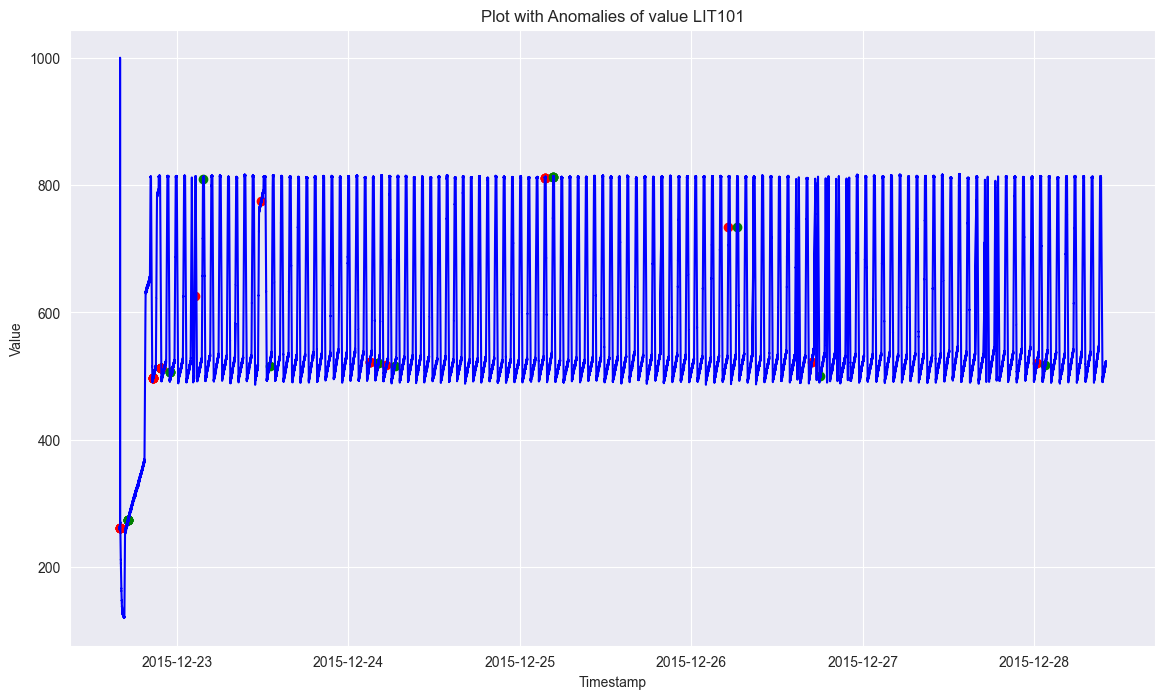

In [50]:
# Define the number of bins
num_bins = 15
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['LIT101'], num_bins, labels=False, duplicates='drop')
# Define the length of the sliding window for N-grams
n_gram_length = 5
M = 4200
# Create sliding windows and extract N-grams
n_grams = []
for i in tqdm(range(len(df1_ngram) - n_gram_length + 1)):
    window = df1_ngram['bin'].iloc[i:i+n_gram_length]
    n_gram = tuple(window)
    n_grams.append(n_gram)

# Add the N-grams to the DataFrame
df1_ngram['n_gram'] = [None] * (n_gram_length - 1) + n_grams
# Group by the larger sliding window and N-gram, and count occurrences
n_gram_counts = df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')

# Pivot the dataframe
table = n_gram_counts.pivot(columns='n_gram', values='count').fillna(0)
# Calculate pairwise cosine distances
distances = cosine_distances(table)
del table
# Find the nearest neighbor for each row
nearest_neighbors = distances.argsort(axis=1)[:, 1]
nearest_neighbor_distances = distances[np.arange(len(distances)), nearest_neighbors]
del distances

anomalies = []
for i in range(len(nearest_neighbor_distances)):
    if nearest_neighbor_distances[i] > 0:
        # Get the index of the sliding window that is seen as an anomalie
        anomalies.append(df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')['level_0'][i])
print(len(nearest_neighbor_distances))
del n_gram_counts
del nearest_neighbor_distances
del nearest_neighbors

timestamps = df1_ngram['Timestamp']
timestamps = [timestamps[i] for i in range(0, len(timestamps))]
values = df1_ngram['LIT101']
plt.rcParams['figure.figsize'] = [14, 8]
# Plot the values
plt.plot(timestamps, values, color='blue')

# Highlight anomalies with a different color
for idx in anomalies:
    plt.scatter(timestamps[idx * M], values[idx * M], color='red')
    plt.scatter(timestamps[idx * M + M], values[idx * M + M], color='green')
del anomalies
# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot with Anomalies of value LIT101')
# plt.ylim(800, 1025)

# Show the plot
plt.show()
del values
del timestamps

100%|██████████| 496796/496796 [00:17<00:00, 28891.38it/s]


1147


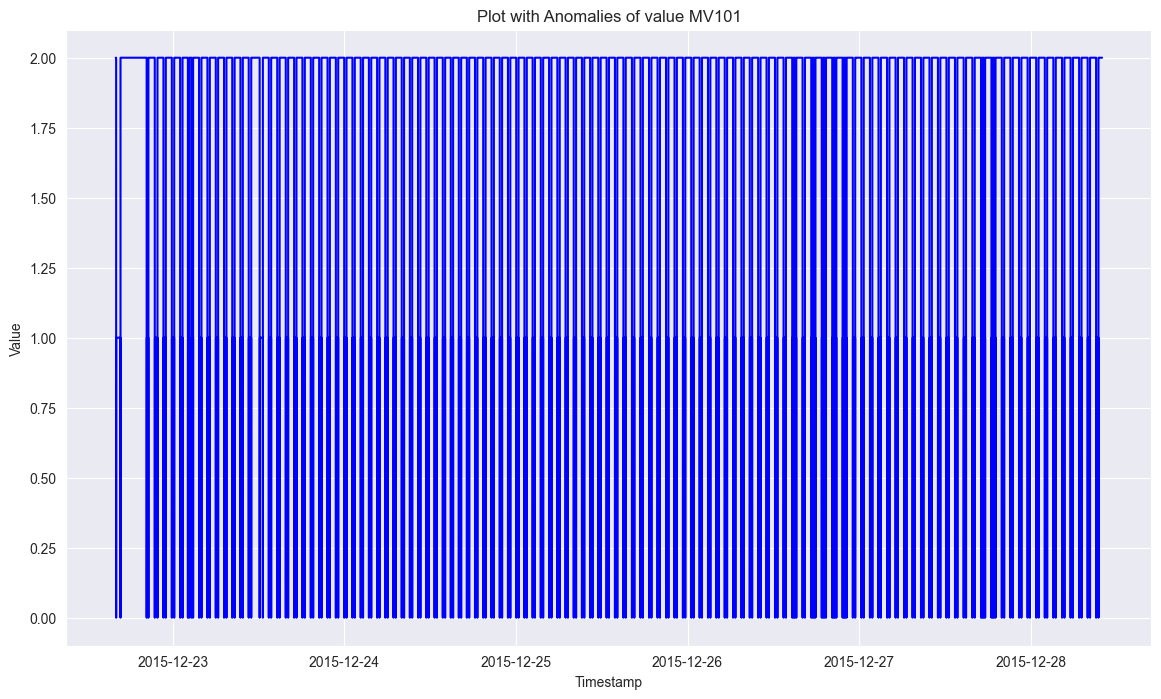

In [38]:
# Define the number of bins
num_bins = 15
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['MV101'], num_bins, labels=False, duplicates='drop')
# Define the length of the sliding window for N-grams
n_gram_length = 5
M = 4200
# Create sliding windows and extract N-grams
n_grams = []
for i in tqdm(range(len(df1_ngram) - n_gram_length + 1)):
    window = df1_ngram['bin'].iloc[i:i+n_gram_length]
    n_gram = tuple(window)
    n_grams.append(n_gram)

# Add the N-grams to the DataFrame
df1_ngram['n_gram'] = [None] * (n_gram_length - 1) + n_grams
# Group by the larger sliding window and N-gram, and count occurrences
n_gram_counts = df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')

# Pivot the dataframe
table = n_gram_counts.pivot(columns='n_gram', values='count').fillna(0)
# Calculate pairwise cosine distances
distances = cosine_distances(table)
del table
# Find the nearest neighbor for each row
nearest_neighbors = distances.argsort(axis=1)[:, 1]
nearest_neighbor_distances = distances[np.arange(len(distances)), nearest_neighbors]
del distances

anomalies = []
for i in range(len(nearest_neighbor_distances)):
    if nearest_neighbor_distances[i] > 0:
        # Get the index of the sliding window that is seen as an anomalie
        anomalies.append(df1_ngram.groupby(df1_ngram.index // M)['n_gram'].value_counts().reset_index(name='count')['level_0'][i])
print(len(nearest_neighbor_distances))
del n_gram_counts
del nearest_neighbor_distances
del nearest_neighbors

timestamps = df1_ngram['Timestamp']
timestamps = [timestamps[i] for i in range(0, len(timestamps))]
values = df1_ngram['MV101']
plt.rcParams['figure.figsize'] = [14, 8]
# Plot the values
plt.plot(timestamps, values, color='blue')

# Highlight anomalies with a different color
for idx in anomalies:
    plt.scatter(timestamps[idx * M], values[idx * M], color='red')
    plt.scatter(timestamps[idx * M + M], values[idx * M + M], color='green')
del anomalies
# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot with Anomalies of value MV101')
# plt.ylim(800, 1025)

# Show the plot
plt.show()
del values
del timestamps

### Effect on different values
The N-gram also works well on another similar value LIT101 since this takes on continuous values. It does however do not find any anomalies the MV101 value since it only takes on 3 values and the transitions are therefor very common.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.